# Assignment 1

Deadline: 19.03.2025, 12:00 CET

<Add your name, student-id and emal address>
* Zihan Liu, 22-736-938,zihan.liu@uzh.ch
* Yujie Tao, 23-744-378,yujie.tao@uzh.ch
* Weijie Chen, 23-743-727,weijie.chen@uzh.ch


In [1]:
# Import standard libraries
import os
import sys
from typing import Optional

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local modules
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   # Change this path if needed
src_path = os.path.join(project_root, 'qpmwp/src')
sys.path.append(project_root)
sys.path.append(src_path)
print(sys.path)
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.constraints import Constraints
from optimization.optimization import Optimization, Objective
from optimization.optimization_data import OptimizationData
from optimization.quadratic_program import QuadraticProgram, USABLE_SOLVERS

['/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/zihanliu/Library/Python/3.9/lib/python/site-packages', '/Users/zihanliu/Library/Python/3.9/lib/python/site-packages/cmeel.prefix/lib/python3.9/site-packages', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/site-packages', '/Users/zihanliu/Documents/Github', '/Users/zihanliu/Documents/Github/qpmwp/src']


## 1. Solver Horse Race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

In [2]:

# Set the dimensions
T = 1000  # Number of time periods
N = 100   # Number of assets

# Generate a random mean vector and covariance matrix for the multivariate normal distribution
mean = np.random.rand(N)  # Random mean vector
cov = np.random.rand(N, N)  # Random covariance matrix
cov = (cov + cov.T) / 2  # Make it symmetric
cov += N * np.eye(N)  # Ensure it's positive definite

# Generate the Multivariate-Normal random dataset
data = np.random.multivariate_normal(mean, cov, size=T)

# Convert the dataset to a DataFrame for easier manipulation
df = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# Compute the vector of expected returns (mean returns) from df
expected_return = ExpectedReturn()
expected_return.estimate(df)
q = expected_return.vector

# Compute the covariance matrix from df
covariance = Covariance()
covariance.estimate(df)
P = covariance.matrix

# Display the results
print("Vector of expected returns (q):")
print(q)

print("\nCovariance matrix (P):")
print(P)

Vector of expected returns (q):
Asset_1      5.089065
Asset_2      4.875746
Asset_3      4.725374
Asset_4      4.722799
Asset_5      4.648003
               ...   
Asset_96     4.889797
Asset_97     4.555307
Asset_98     4.494240
Asset_99     4.395943
Asset_100    5.367785
Length: 100, dtype: float64

Covariance matrix (P):
              Asset_1    Asset_2    Asset_3    Asset_4    Asset_5   Asset_6  \
Asset_1    101.935576  -2.523688   4.401883   1.796699   4.806350  0.681484   
Asset_2     -2.523688  96.928490   0.019863   0.130762   7.122894 -0.538998   
Asset_3      4.401883   0.019863  97.270048  -2.231538  -1.086491  2.753405   
Asset_4      1.796699   0.130762  -2.231538  99.263297   1.077136 -5.356146   
Asset_5      4.806350   7.122894  -1.086491   1.077136  95.388644 -2.725766   
...               ...        ...        ...        ...        ...       ...   
Asset_96     6.408243   3.380917   4.301300   0.777037   0.963192 -1.237833   
Asset_97     0.736964   2.480213   3.43481

/Users/zihanliu/Library/Python/3.9/lib/python/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

In [3]:
# Instantiate the Constraints class
constraints = Constraints(ids = df.columns.tolist())

# Add budget constraints
constraints.add_budget()

# Add box constraints (i.e., lower and upper bounds)
constraints.add_box(lower=0.0, upper=0.2)

# Define group constraints
group_1_assets = df.columns[:30]  # First 30 assets
group_2_assets = df.columns[30:60]  # Assets 31-60
group_3_assets = df.columns[60:100]  # Assets 61-100

# Create linear constraints for each group
g_values_1 = pd.Series(1, index=group_1_assets)
g_values_2 = pd.Series(1, index=group_2_assets)
g_values_3 = pd.Series(1, index=group_3_assets)

# Add linear constraints
constraints.add_linear(g_values=g_values_1, sense='<=', rhs=0.3, name="Group 1")
constraints.add_linear(g_values=g_values_2, sense='<=', rhs=0.4, name="Group 2")
constraints.add_linear(g_values=g_values_3, sense='<=', rhs=0.5, name="Group 3")

### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
    Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

    - runtime
    - accuracy: value of the primal problem.
    - reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution). 

In [4]:
import numpy as np
import pandas as pd
import time
import qpsolvers
from qpsolvers import solve_qp

# Extract the constraints in the format required by the solver
GhAb = constraints.to_GhAb()

G = GhAb['G']
h = GhAb['h']
A = GhAb['A']
b = GhAb['b']

# Convert to NumPy arrays
P_matrix = np.array(P, dtype=np.float64) if isinstance(P, pd.DataFrame) else P
q_vector = np.array(q, dtype=np.float64).flatten() if isinstance(q, pd.Series) else q

G = np.array(G, dtype=np.float64) if G is not None else None
h = np.array(h, dtype=np.float64).flatten() if h is not None else None
A = np.array(A, dtype=np.float64) if A is not None else None
b = np.array(b, dtype=np.float64).flatten() if b is not None else None

# List of solvers to test
solvers = qpsolvers.available_solvers
print(f"Available solvers: {solvers}")

# Initialize results dictionary
results = {}

# Loop over solvers, instantiate the quadratic program, solve it and store results
for solver in solvers:
    try:
        print(f"Testing solver: {solver}")

        P_solver, q_solver, G_solver, h_solver, A_solver, b_solver = P_matrix, q_vector, G, h, A, b

        # Start solving
        start_time = time.time()
        solution = solve_qp(P_solver, -q_solver, G_solver, h_solver, A_solver, b_solver, solver=solver)
        runtime = time.time() - start_time

        if solution is not None:
            # Compute objective value(accuracy)
            objective = 0.5 * solution.T @ P_matrix @ solution - q_vector.T @ solution

            # Compute residuals
            primal_residual = np.linalg.norm(G @ solution - h) if G is not None else 0
            dual_residual = np.linalg.norm(A @ solution - b) if A is not None else 0
            duality_gap = abs(objective + q_vector.T @ solution)

            # Store results
            print(f"Solver {solver} completed successfully")
            results[solver] = {
                'solution_found': True,
                'objective': objective,
                'primal_residual': primal_residual,
                'dual_residual': dual_residual,
                'duality_gap': duality_gap,
                'runtime': runtime,
                'solution': solution
            }
        else:
            print(f"Solver {solver} failed to find a solution")
            results[solver] = {
                'solution_found': False,
                'objective': np.nan,
                'primal_residual': np.nan,
                'dual_residual': np.nan,
                'duality_gap': np.nan,
                'runtime': np.nan,
                'solution': np.nan,
            }
    
    except Exception as e:
        print(f"Solver {solver} failed with error: {e}")
        results[solver] = {
            'solution_found': False,
            'objective': np.nan,
            'primal_residual': np.nan,
            'dual_residual': np.nan,
            'duality_gap': np.nan,
            'runtime': np.nan
        }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

Available solvers: ['clarabel', 'cvxopt', 'daqp', 'ecos', 'highs', 'osqp', 'piqp', 'qpalm', 'quadprog', 'scs', 'qpax']
Testing solver: clarabel
Solver clarabel completed successfully
Testing solver: cvxopt
Solver cvxopt completed successfully
Testing solver: daqp
Solver daqp completed successfully
Testing solver: ecos
Solver ecos completed successfully
Testing solver: highs
Solver highs completed successfully
Testing solver: osqp
Solver osqp completed successfully
Testing solver: piqp
Solver piqp completed successfully
Testing solver: qpalm
Solver qpalm completed successfully
Testing solver: quadprog
Solver quadprog completed successfully
Testing solver: scs
Solver scs completed successfully
Testing solver: qpax


/Users/zihanliu/Library/Python/3.9/lib/python/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/Users/zihanliu/Library/Python/3.9/lib/python/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/Users/zihanliu/Library/Python/3.9/lib/python/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


Solver qpax completed successfully


Print and visualize the results

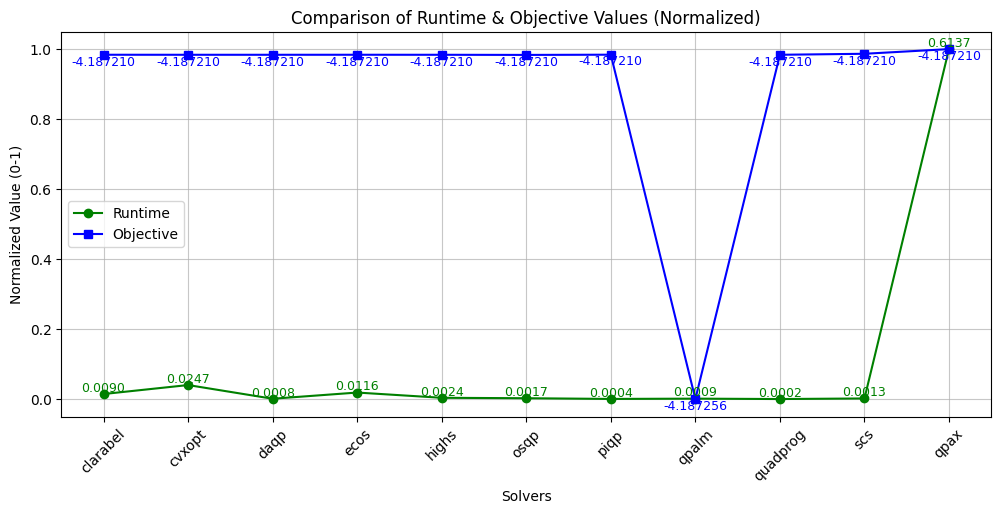

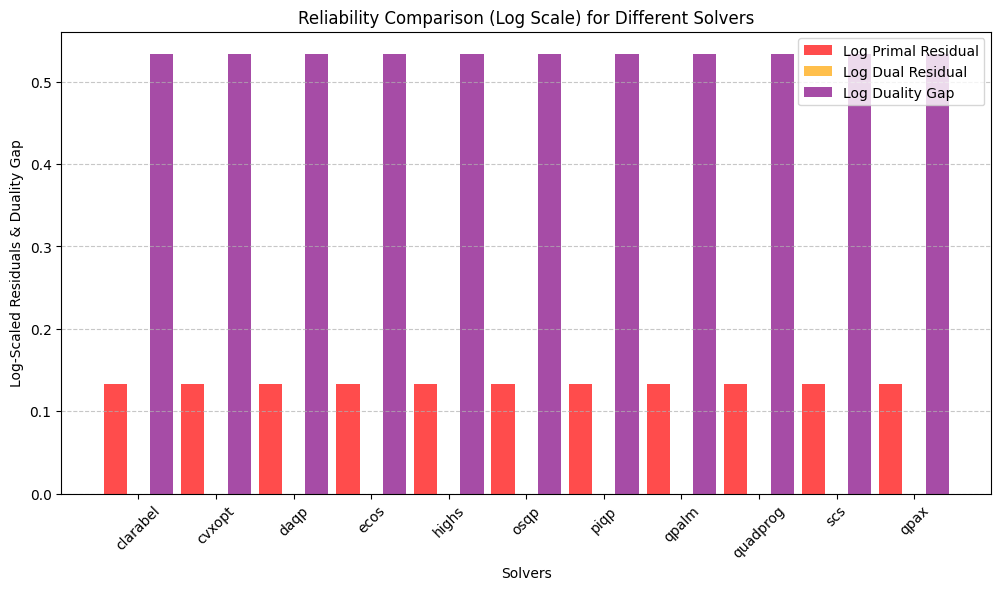

In [5]:
import matplotlib.pyplot as plt
import numpy as np

solvers = results_df.index.tolist()
runtime_values = results_df["runtime"].astype(float).tolist()
objective_values = results_df["objective"].astype(float).tolist()
primal_residuals = results_df["primal_residual"].astype(float).tolist()
dual_residuals = results_df["dual_residual"].astype(float).tolist()
duality_gaps = results_df["duality_gap"].astype(float).tolist()

def min_max_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-8)

runtime_values_scaled = min_max_scale(np.array(runtime_values))
objective_values_scaled = min_max_scale(np.array(objective_values))
primal_residuals_scaled = min_max_scale(np.array(primal_residuals))
dual_residuals_scaled = min_max_scale(np.array(dual_residuals))
duality_gaps_scaled = min_max_scale(np.array(duality_gaps))

plt.figure(figsize=(12, 5))
plt.plot(solvers, runtime_values_scaled, marker='o', linestyle='-', color='green', label="Runtime")
plt.plot(solvers, objective_values_scaled, marker='s', linestyle='-', color='blue', label="Objective")
plt.xticks(rotation=45)
for i, solver in enumerate(solvers):
    plt.text(i, runtime_values_scaled[i], f"{runtime_values[i]:.4f}", ha='center', va='bottom', fontsize=9, color='green')
    plt.text(i, objective_values_scaled[i], f"{objective_values[i]:.6f}", ha='center', va='top', fontsize=9, color='blue')

plt.xlabel("Solvers")
plt.ylabel("Normalized Value (0-1)")
plt.title("Comparison of Runtime & Objective Values (Normalized)")
plt.legend()
plt.grid(alpha=0.7)
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(solvers))
width = 0.3 

ax.bar(x - width, np.log1p(primal_residuals), width, label="Log Primal Residual", color='red', alpha=0.7)
ax.bar(x, np.log1p(dual_residuals), width, label="Log Dual Residual", color='orange', alpha=0.7)
ax.bar(x + width, np.log1p(duality_gaps), width, label="Log Duality Gap", color='purple', alpha=0.7)

ax.set_xlabel("Solvers")
ax.set_ylabel("Log-Scaled Residuals & Duality Gap")
ax.set_title("Reliability Comparison (Log Scale) for Different Solvers")
ax.set_xticks(x)
ax.set_xticklabels(solvers, rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).


In [ ]:
# Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
class MinVariance(Optimization):

    def __init__(self,
                 constraints: Constraints,
                 covariance: Optional[Covariance] = None,
                 **kwargs):
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance

    def set_objective(self, optimization_data: OptimizationData) -> None:
        self.objective = {
            'P': self.covariance.matrix,
            'q': np.zeros(self.covariance.matrix.shape[0]) 
        }

    # Implement the `solve` method 
    def solve(self) -> None:
        if self.params.get('solver_name') == 'analytical':
            try:
                P_inv = np.linalg.inv(self.covariance.matrix)
                ones = np.ones((self.covariance.matrix.shape[0], 1))
                w_min_var = P_inv @ ones / (ones.T @ P_inv @ ones)

                self.solution = w_min_var.flatten()
                print("Analytical Minimum Variance Portfolio found successfully.")
                return None
            except np.linalg.LinAlgError:
                print("Covariance matrix is singular, using numerical solver instead.")
                return super().solve()
        else:
            return super().solve()


# Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
constraints = Constraints(ids=df.columns.tolist())
constraints.add_budget()

# Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
min_variance_solver = MinVariance(
    constraints=constraints,
    covariance=Covariance(),
    solver_name='analytical'
)

# Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
optimization_data = OptimizationData(return_series=df)

# solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).
min_variance_solver.covariance.estimate(optimization_data.return_series)

min_variance_solver.solve()

analytical_weights = min_variance_solver.solution

Analytical Minimum Variance Portfolio found successfully.
Optimal Minimum Variance Portfolio Weights (Analytical):
[0.00888969 0.00495313 0.00437734 0.01255058 0.01167034 0.00915478
 0.00863447 0.00860864 0.01404193 0.01611317 0.00992262 0.00980538
 0.00665849 0.02224382 0.00743651 0.00495865 0.00463242 0.00764127
 0.00854044 0.00764116 0.01844546 0.01305072 0.00889024 0.01489034
 0.01090663 0.00625726 0.0024588  0.01191229 0.00708611 0.01207865
 0.01273415 0.01008701 0.00711698 0.00758083 0.00870913 0.01122383
 0.01483687 0.01471146 0.01077034 0.01389701 0.00979183 0.00577305
 0.00888794 0.01444455 0.00712171 0.01203215 0.01395457 0.01308567
 0.01375657 0.00721351 0.01130566 0.00595376 0.00742371 0.01027428
 0.00947848 0.00589037 0.01085724 0.01076087 0.01076327 0.01439699
 0.01325881 0.00738685 0.01628558 0.01008656 0.01225037 0.00903224
 0.0142893  0.01060157 0.00547631 0.00982037 0.01226394 0.01190905
 0.0135996  0.00407839 0.00397655 0.01054952 0.00257311 0.00777502
 0.01271268 0.

In [ ]:
print("Optimal Minimum Variance Portfolio Weights (Analytical):")
print(analytical_weights)

best_solver = "qpalm" # according to the results from the previous section
best_solver_weights = results[best_solver]['solution']
print(f"Optimal Minimum Variance Portfolio Weights ({best_solver}):")
print(best_solver_weights)

Optimal Minimum Variance Portfolio Weights (Analytical):
[0.00888969 0.00495313 0.00437734 0.01255058 0.01167034 0.00915478
 0.00863447 0.00860864 0.01404193 0.01611317 0.00992262 0.00980538
 0.00665849 0.02224382 0.00743651 0.00495865 0.00463242 0.00764127
 0.00854044 0.00764116 0.01844546 0.01305072 0.00889024 0.01489034
 0.01090663 0.00625726 0.0024588  0.01191229 0.00708611 0.01207865
 0.01273415 0.01008701 0.00711698 0.00758083 0.00870913 0.01122383
 0.01483687 0.01471146 0.01077034 0.01389701 0.00979183 0.00577305
 0.00888794 0.01444455 0.00712171 0.01203215 0.01395457 0.01308567
 0.01375657 0.00721351 0.01130566 0.00595376 0.00742371 0.01027428
 0.00947848 0.00589037 0.01085724 0.01076087 0.01076327 0.01439699
 0.01325881 0.00738685 0.01628558 0.01008656 0.01225037 0.00903224
 0.0142893  0.01060157 0.00547631 0.00982037 0.01226394 0.01190905
 0.0135996  0.00407839 0.00397655 0.01054952 0.00257311 0.00777502
 0.01271268 0.01096744 0.01176891 0.00802513 0.00738496 0.00301276
 0.01

In [10]:
risk_min_var = analytical_weights.T @ P_matrix @ analytical_weights
risk_mvo = best_solver_weights .T @ P_matrix @ best_solver_weights 

print(f"Minimum Variance Portfolio Risk: {risk_min_var:.6f}")
print(f"Mean-Variance Portfolio (QPALM) Risk: {risk_mvo:.6f}")

Minimum Variance Portfolio Risk: 1.324865
Mean-Variance Portfolio (QPALM) Risk: 1.411806


In [11]:
budget_error_min_var = abs(np.sum(analytical_weights) - 1)
budget_error_mvo = abs(np.sum(best_solver_weights ) - 1)

print(f"Budget Constraint Error (Min-Var): {budget_error_min_var:.6e}")
print(f"Budget Constraint Error (MVO - QPALM): {budget_error_mvo:.6e}")


Budget Constraint Error (Min-Var): 1.110223e-16
Budget Constraint Error (MVO - QPALM): 1.361445e-05


In [12]:
weight_difference = np.linalg.norm(analytical_weights - best_solver_weights)

print(f"Weight Difference (L2 Norm) between Min-Var and MVO: {weight_difference:.6f}")

Weight Difference (L2 Norm) between Min-Var and MVO: 0.032836


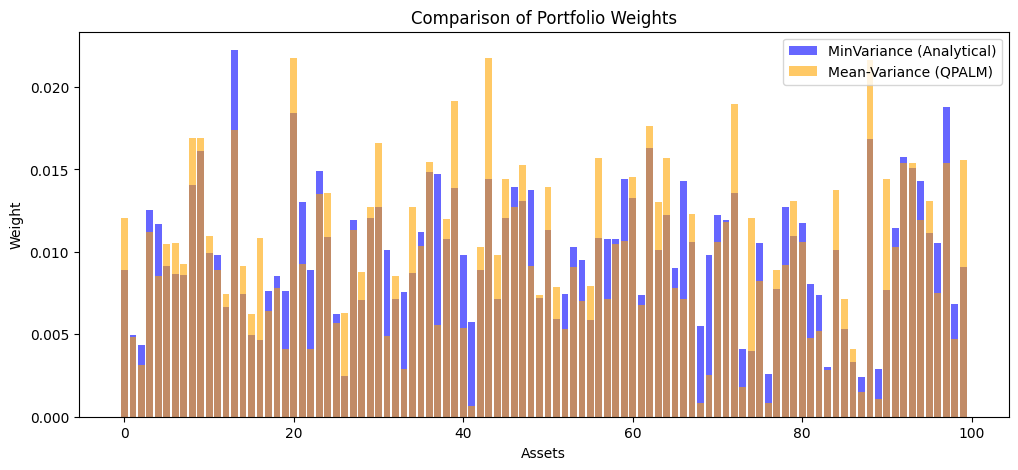

In [14]:
import matplotlib.pyplot as plt

solvers = range(len(analytical_weights))

plt.figure(figsize=(12, 5))
plt.bar(solvers, analytical_weights, color='blue', alpha=0.6, label="MinVariance (Analytical)")
plt.bar(solvers, best_solver_weights, color='orange', alpha=0.6, label="Mean-Variance (QPALM)")
plt.xlabel("Assets")
plt.ylabel("Weight")
plt.title("Comparison of Portfolio Weights")
plt.legend()
plt.show()